**LSTM**

📚 Epoch 1, Loss: 66.1774
📚 Epoch 2, Loss: 42.9340
📚 Epoch 3, Loss: 34.4213
📚 Epoch 4, Loss: 28.2186
📚 Epoch 5, Loss: 24.1139

✅ Accuracy: 0.9358789625360231

📊 Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.92      0.93       613
    POSITIVE       0.94      0.95      0.94       775

    accuracy                           0.94      1388
   macro avg       0.94      0.93      0.93      1388
weighted avg       0.94      0.94      0.94      1388



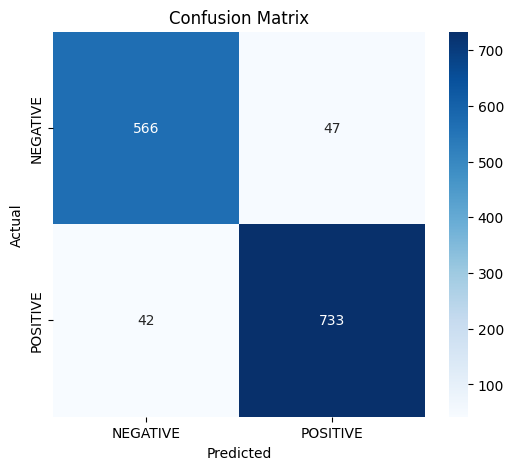

In [15]:
# 1. Install scikit-learn jika belum
!pip install -q scikit-learn

# 2. Import library
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# 3. Load data dengan penanganan error
df = pd.read_csv(
    '/content/Combined Data.csv',
    encoding='utf-8',
    on_bad_lines='skip',         # Lewati baris rusak
    quoting=csv.QUOTE_NONE,      # Abaikan tanda kutip yang tidak lengkap
    engine='python'              # Gunakan parser yang lebih toleran
)

# 4. Buat label dari kolom 'status'
def map_status_to_sentiment(status):
    status = str(status).lower()
    return 'POSITIVE' if 'normal' in status else 'NEGATIVE'

df['Sentiment_Asli'] = df['status'].apply(map_status_to_sentiment)

# 5. Tokenisasi sederhana
def tokenize(text):
    return str(text).lower().split()

# 6. Bangun vocabulary dari token
counter = Counter()
for text in df['statement']:
    counter.update(tokenize(text))

vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# 7. Encoding teks
def encode(text, max_len=50):
    tokens = tokenize(text)
    ids = [vocab.get(token, 1) for token in tokens][:max_len]
    return ids + [0] * (max_len - len(ids))

# 8. Encoding label
label_enc = LabelEncoder()
df['label'] = label_enc.fit_transform(df['Sentiment_Asli'])  # 0=NEGATIVE, 1=POSITIVE

# 9. Dataset PyTorch
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.X = [encode(text) for text in texts]
        self.y = labels

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

# 10. Split train-test
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['label'], test_size=0.2, random_state=42)

train_ds = TextDataset(X_train.tolist(), y_train.values)
test_ds = TextDataset(X_test.tolist(), y_test.values)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=32)

# 11. LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# 12. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# 13. Training Loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📚 Epoch {epoch+1}, Loss: {total_loss:.4f}")

# 14. Evaluasi Model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# 15. Evaluasi Akurasi dan Laporan
print("\n✅ Accuracy:", accuracy_score(all_labels, all_preds))
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_enc.classes_))

# 16. Visualisasi Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
